In [1]:
# Exploration of possible features to pull from name.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.tree import DecisionTreeRegressor

In [3]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [4]:
# For now, just set all NaN to 0.
means = all_df.drop('Page', axis = 1).mean(axis = 1)
means.fillna(0, inplace = True)

for column in all_df.columns:
    
    all_df[column].fillna(means, inplace = True)

all_df[:10]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.000000,11.000000,5.000000,13.000000,14.000000,9.000000,9.000000,22.000000,26.000000,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.000000,14.000000,15.000000,18.000000,11.000000,13.000000,22.000000,11.000000,10.000000,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.000000,0.000000,1.000000,1.000000,0.000000,4.000000,0.000000,3.000000,4.000000,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.000000,13.000000,10.000000,94.000000,4.000000,26.000000,14.000000,9.000000,11.000000,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,10.277992,10.277992,10.277992,10.277992,10.277992,10.277992,10.277992,10.277992,10.277992,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
5,5566_zh.wikipedia.org_all-access_spider,12.000000,7.000000,4.000000,5.000000,20.000000,8.000000,5.000000,17.000000,24.000000,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
6,91Days_zh.wikipedia.org_all-access_spider,19.691892,19.691892,19.691892,19.691892,19.691892,19.691892,19.691892,19.691892,19.691892,...,2.0,7.0,33.0,8.0,11.0,4.0,15.0,6.0,8.0,6.0
7,A'N'D_zh.wikipedia.org_all-access_spider,118.000000,26.000000,30.000000,24.000000,29.000000,127.000000,53.000000,37.000000,20.000000,...,64.0,35.0,35.0,28.0,20.0,23.0,32.0,39.0,32.0,17.0
8,AKB48_zh.wikipedia.org_all-access_spider,5.000000,23.000000,14.000000,12.000000,9.000000,9.000000,35.000000,15.000000,14.000000,...,34.0,105.0,72.0,36.0,33.0,30.0,36.0,38.0,31.0,97.0
9,ASCII_zh.wikipedia.org_all-access_spider,6.000000,3.000000,5.000000,12.000000,6.000000,5.000000,4.000000,13.000000,9.000000,...,25.0,17.0,22.0,29.0,30.0,29.0,35.0,44.0,26.0,41.0


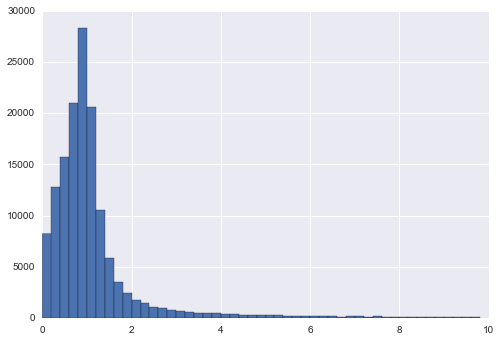

0.0517912906806


,ratios,logratios
0,1.221424,0.200018
1,1.247793,0.221377
2,1.492083,0.400174
3,0.984510,-0.015610
4,1.598463,0.469043


In [5]:
futureT = 64
epsilon = 1e-6

X_mean = all_df.drop(['Page'], axis = 1).values[:, :-futureT].mean(axis = 1)
Y_mean = all_df.drop(['Page'], axis = 1).values[:, -futureT:].mean(axis = 1)

name_df = pd.DataFrame(data =  Y_mean / (X_mean + epsilon), columns = ['ratios'])
name_df['logratios'] = np.log(name_df.ratios + epsilon)

name_df.ratios.hist(bins = np.arange(0, 10, 0.2))
plt.show()

print(np.sum(name_df.ratios > 4) / len(name_df.ratios))
name_df.head()

In [6]:
urlRegEx = '[^._]+[.]\w*wiki\w*[.][^_]+'

# Extract info from page

pageInfo = []

for pageStr in all_df.Page.values:
    midSplit = re.split('[_](' + urlRegEx + ')[_]', pageStr)
    thisPageInfo = midSplit[:2]
    midSplit = re.split('[_]', midSplit[2])
    thisPageInfo.extend(midSplit)
    
    pageInfo.append(thisPageInfo)
    
# Do a transpose, now in shape nInfo, nSamples

pageInfo = [[pageInfo[j][i] for j in range(len(pageInfo))] for i in range(len(pageInfo[0]))]

toInfoIndex = {'name' : 0, 'project' : 1, 'access' : 2, 'agent' : 3}
colNames = ['name', 'project', 'access', 'agent']

name_df['name'] = pageInfo[0]

# Convert info to numerical

for i in range(1, 4):
    name = colNames[i]
    infoCol = np.array(pageInfo[i])
    infoCol_vals = np.unique(infoCol)
    infoCol_map = dict(zip(infoCol_vals, np.arange(len(infoCol_vals))))
    infoCol = [infoCol_map[x] for x in infoCol]
    name_df[name] = infoCol
    #all_df.insert(i, name, infoCol)

name_df.head()

,ratios,logratios,name,project,access,agent
0,1.221424,0.200018,2NE1,9,0,3
1,1.247793,0.221377,2PM,9,0,3
2,1.492083,0.400174,3C,9,0,3
3,0.984510,-0.015610,4minute,9,0,3
4,1.598463,0.469043,52_Hz_I_Love_You,9,0,3


In [7]:
numWords = []

for name in name_df['name']:
    num = len(re.split(r'_', name))
    numWords.append(num)
        
numWords = np.array(numWords)

name_df['numWords'] = numWords

name_df.head()

,ratios,logratios,name,project,access,agent,numWords
0,1.221424,0.200018,2NE1,9,0,3,1
1,1.247793,0.221377,2PM,9,0,3,1
2,1.492083,0.400174,3C,9,0,3,1
3,0.984510,-0.015610,4minute,9,0,3,1
4,1.598463,0.469043,52_Hz_I_Love_You,9,0,3,5


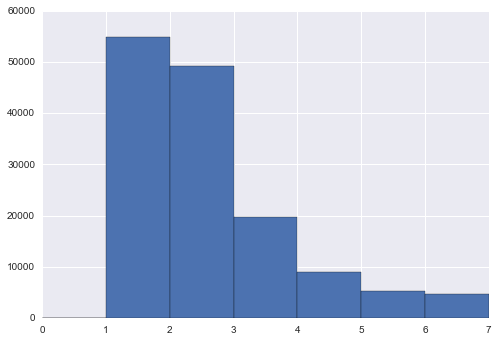

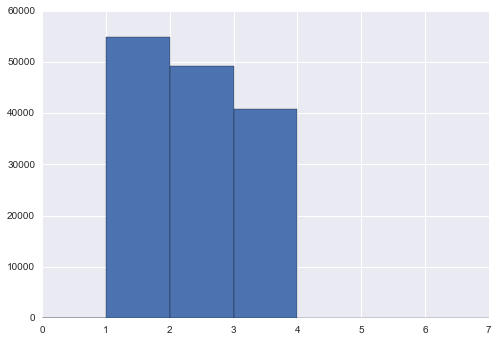

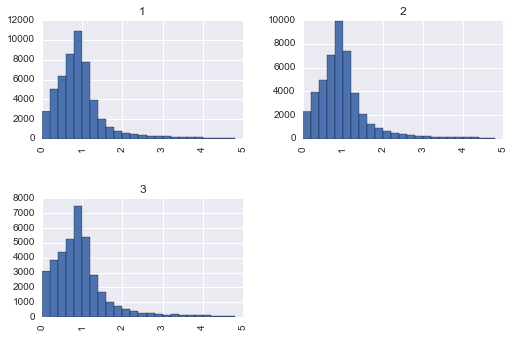

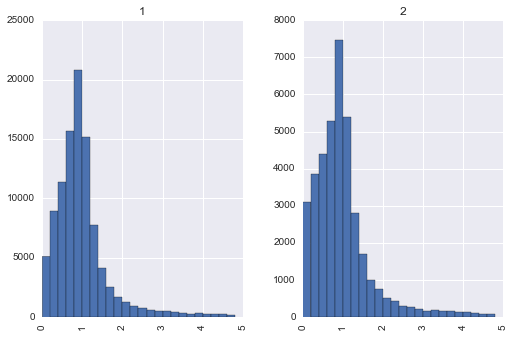

In [8]:
name_df['numWords'].hist(bins = np.arange(8))
plt.show()

name_df['numWords2'] = name_df['numWords']

name_df.loc[name_df['numWords'] > 3, 'numWords2'] = 3
name_df['numWords2'].hist(bins = np.arange(8))
plt.show()

name_df['ratios'].hist(by = name_df['numWords2'], bins = np.arange(0, 5, 0.2))
plt.show()

name_df.loc[name_df.numWords2 < 3, 'numWords2'] = 1
name_df.loc[name_df.numWords2 > 2, 'numWords2'] = 2

name_df['ratios'].hist(by = name_df['numWords2'], bins = np.arange(0, 5, 0.2))
plt.show()

In [9]:
numNums = []
for name in name_df['name']:
    num = len(re.split(r'\d', name))
    numNums.append(num)
        
numNums = np.array(numNums)

name_df['numNums'] = numWords

name_df.head()

,ratios,logratios,name,project,access,agent,numWords,numWords2,numNums
0,1.221424,0.200018,2NE1,9,0,3,1,1,1
1,1.247793,0.221377,2PM,9,0,3,1,1,1
2,1.492083,0.400174,3C,9,0,3,1,1,1
3,0.984510,-0.015610,4minute,9,0,3,1,1,1
4,1.598463,0.469043,52_Hz_I_Love_You,9,0,3,5,2,5


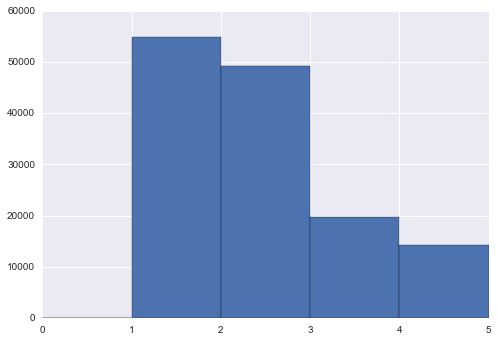

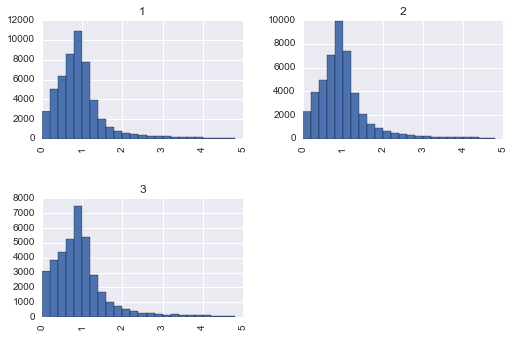

numNums2
1    0.981949
2    1.029613
3    0.997098
Name: ratios, dtype: float64


,ratios,logratios,name,project,access,agent,numWords,numWords2,numNums,numNums2
0,1.221424,0.200018,2NE1,9,0,3,1,1,1,1
1,1.247793,0.221377,2PM,9,0,3,1,1,1,1
2,1.492083,0.400174,3C,9,0,3,1,1,1,1
3,0.984510,-0.015610,4minute,9,0,3,1,1,1,1
4,1.598463,0.469043,52_Hz_I_Love_You,9,0,3,5,2,5,3


In [10]:
name_df.numNums.hist(bins = np.arange(6))
plt.show()
name_df['numNums2'] = name_df.numNums

name_df.loc[name_df.numNums2 > 3, 'numNums2'] = 3
name_df['ratios'].hist(by = name_df.numNums2, bins = np.arange(0, 5, 0.2))
plt.show()

print(name_df[name_df.ratios < 5].groupby('numNums2').mean().ratios)

name_df.head()

In [11]:
# Let's look at statistics of numbers inside names.

numSize = []
matches = []
for name in name_df['name']:
    match = re.search(r'\d+', name)
    matches.append(match)
    if match != None:
        num = float(match.group())
    else:
        num = 0
    numSize.append(num)

name_df['numSize'] = numSize

name_df.head()

,ratios,logratios,name,project,access,agent,numWords,numWords2,numNums,numNums2,numSize
0,1.221424,0.200018,2NE1,9,0,3,1,1,1,1,2.0
1,1.247793,0.221377,2PM,9,0,3,1,1,1,1,2.0
2,1.492083,0.400174,3C,9,0,3,1,1,1,1,3.0
3,0.984510,-0.015610,4minute,9,0,3,1,1,1,1,4.0
4,1.598463,0.469043,52_Hz_I_Love_You,9,0,3,5,2,5,3,52.0


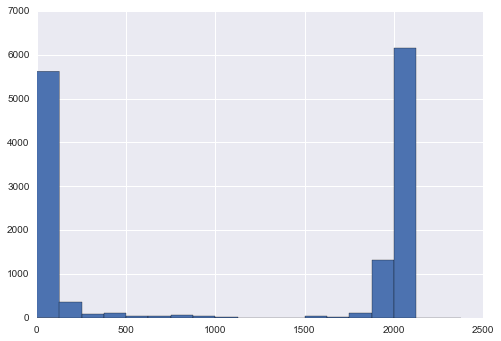

numSize2
0.0    1.017790
1.0    0.895310
2.0    0.840484
Name: ratios, dtype: float64


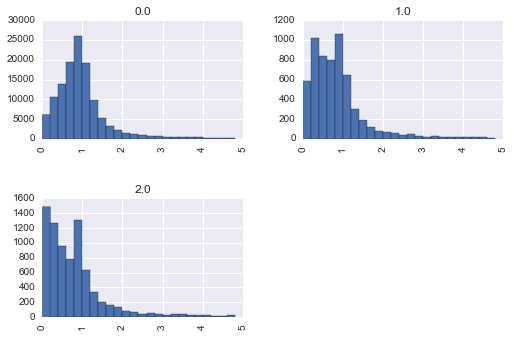

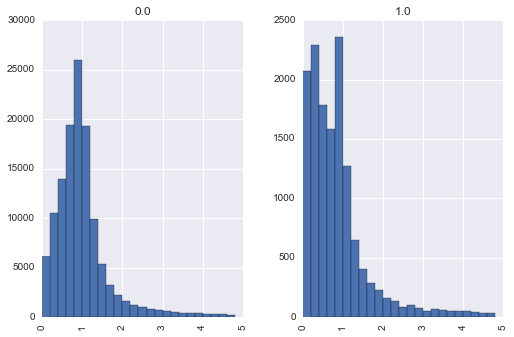

0.10168685329822215

In [12]:
name_df.numSize.hist(bins = np.arange(1, 2.5e3, 2.5e3 / 20))
plt.show()
name_df['numSize2'] = name_df['numSize']

mask = name_df.numSize2 > 0
name_df.loc[mask & (name_df.numSize2 < 1250), 'numSize2'] = 1
name_df.loc[mask & (name_df.numSize2 > 1), 'numSize2'] = 2

print(name_df[name_df.ratios < 5].groupby('numSize2').mean().ratios)

name_df.ratios.hist(by = name_df['numSize2'], bins = np.arange(0, 5, 0.2))
plt.show()

name_df.loc[mask & name_df.numSize2 > 0, 'numSize2'] = 1
name_df.ratios.hist(by = name_df['numSize2'], bins = np.arange(0, 5, 0.2))
plt.show()

np.sum(name_df.numSize > 0) / len(name_df.numSize)

In [13]:
# Let's look at number of capital letters - number of words.

capNums = []
matches = []
for name in name_df['name']:
    match = re.findall(r'[A-Z][A-Z]+', name)
    matches.append(match)
    num = 0
    for s in match:
        num += len(s)
    capNums.append(num)

for i in [0, 4, 6, 8]:
    print('i = ', i, '\t', matches[i], capNums[i])
    
name_df['capNums'] = capNums

name_df.head()

i =  0 	 ['NE'] 2
i =  4 	 [] 0
i =  6 	 [] 0
i =  8 	 ['AKB'] 3


,ratios,logratios,name,project,access,agent,numWords,numWords2,numNums,numNums2,numSize,numSize2,capNums
0,1.221424,0.200018,2NE1,9,0,3,1,1,1,1,2.0,1.0,2
1,1.247793,0.221377,2PM,9,0,3,1,1,1,1,2.0,1.0,2
2,1.492083,0.400174,3C,9,0,3,1,1,1,1,3.0,1.0,0
3,0.984510,-0.015610,4minute,9,0,3,1,1,1,1,4.0,1.0,0
4,1.598463,0.469043,52_Hz_I_Love_You,9,0,3,5,2,5,3,52.0,1.0,0


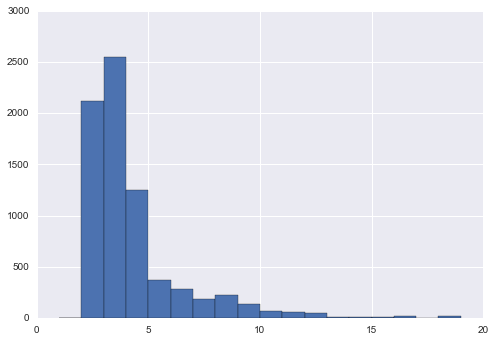

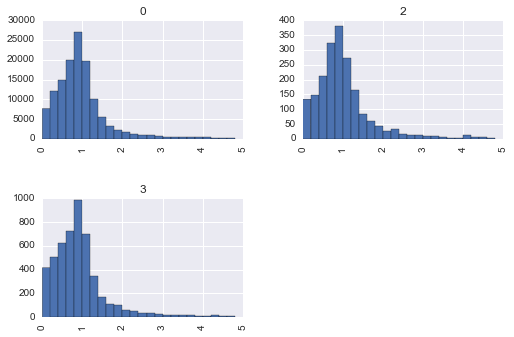

capNums2
0    1.003532
2    1.041988
3    0.956508
Name: ratios, dtype: float64

In [14]:
name_df.capNums.hist(bins = np.arange(1, 20))
plt.show()

name_df['capNums2'] = name_df.capNums
name_df.loc[name_df.capNums2 > 3, 'capNums2'] = 3

name_df.ratios.hist(by = name_df.capNums2, bins = np.arange(0, 5.0, 0.2))
plt.show()

name_df[name_df.ratios < 5].groupby('capNums2').mean().ratios

In [15]:
# Let's look at largest word length

wordLengths = []
for name in name_df['name']:
    words = re.split(r'_|\d', name)
    matches.append(match)
    if words:
        lengths = np.array([len(x) for x in words])
        wordLengths.append(np.amax(lengths))
    else:
        wordLengths.append(0)

for i in [0, 4, 6, 8]:
    print('i = ', i, '\t', wordLengths[i])
    
# put into data frame

name_df['wordLength'] = wordLengths
name_df.head()

i =  0 	 2
i =  4 	 4
i =  6 	 4
i =  8 	 3


,ratios,logratios,name,project,access,agent,numWords,numWords2,numNums,numNums2,numSize,numSize2,capNums,capNums2,wordLength
0,1.221424,0.200018,2NE1,9,0,3,1,1,1,1,2.0,1.0,2,2,2
1,1.247793,0.221377,2PM,9,0,3,1,1,1,1,2.0,1.0,2,2,2
2,1.492083,0.400174,3C,9,0,3,1,1,1,1,3.0,1.0,0,0,1
3,0.984510,-0.015610,4minute,9,0,3,1,1,1,1,4.0,1.0,0,0,6
4,1.598463,0.469043,52_Hz_I_Love_You,9,0,3,5,2,5,3,52.0,1.0,0,0,4


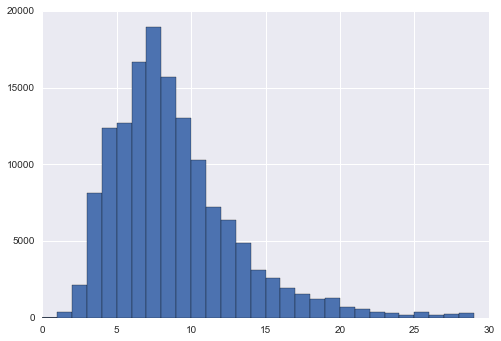

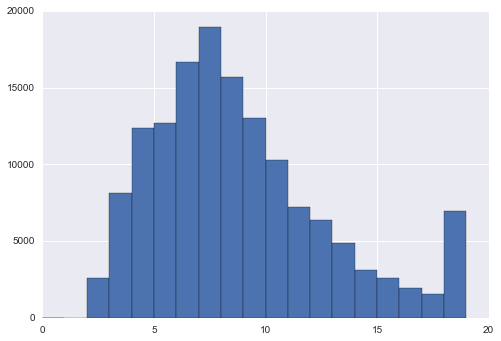

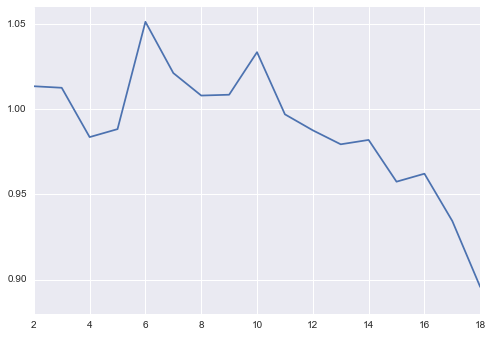

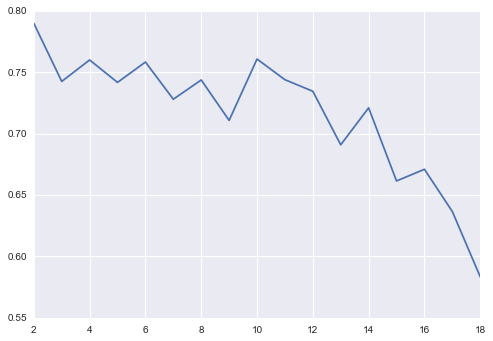

In [16]:
name_df.wordLength.hist(bins = np.arange(30))
plt.show()

name_df['wordLength2'] = name_df.wordLength
name_df.loc[name_df.wordLength2 > 18, 'wordLength2'] = 18
name_df.loc[name_df.wordLength2 < 2, 'wordLength2'] = 2

name_df.wordLength2.hist(bins = np.arange(20))
plt.show()
means = name_df[name_df.ratios < 5].groupby('wordLength2').mean().ratios
stds = name_df[name_df.ratios < 5].groupby('wordLength2').std().ratios
plt.plot(means)
plt.show()
plt.plot(stds)
plt.show()

wordLength2
(0, 2]      1.350227
(2, 4]      1.277793
(4, 6]      1.314933
(6, 8]      1.240595
(8, 10]     1.298465
(10, 12]    1.251270
(12, 14]    1.243437
Name: ratios, dtype: float64


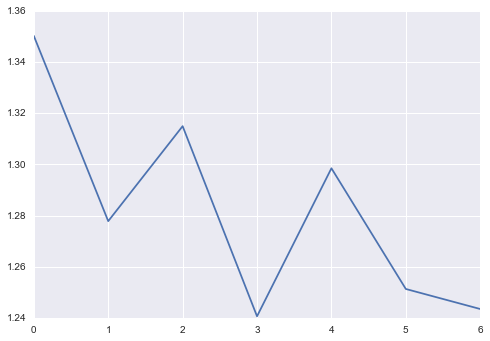

In [17]:
means = name_df[name_df.ratios < 20].groupby(pd.cut(name_df[name_df.ratios < 20].wordLength2, bins = np.arange(0,15,2))).mean().ratios
print(means)
plt.plot(means.values)
plt.show()

In [18]:
name_df.head()

,ratios,logratios,name,project,access,agent,numWords,numWords2,numNums,numNums2,numSize,numSize2,capNums,capNums2,wordLength,wordLength2
0,1.221424,0.200018,2NE1,9,0,3,1,1,1,1,2.0,1.0,2,2,2,2
1,1.247793,0.221377,2PM,9,0,3,1,1,1,1,2.0,1.0,2,2,2,2
2,1.492083,0.400174,3C,9,0,3,1,1,1,1,3.0,1.0,0,0,1,2
3,0.984510,-0.015610,4minute,9,0,3,1,1,1,1,4.0,1.0,0,0,6,6
4,1.598463,0.469043,52_Hz_I_Love_You,9,0,3,5,2,5,3,52.0,1.0,0,0,4,4


In [19]:
feature_cols = ['project', 'access', 'agent', 'numWords2', 'numNums2', 'numSize2', 'capNums2', 'wordLength2']
nameFeatures = name_df[feature_cols].values

timeSeries = all_df.drop(['Page'], axis = 1).values

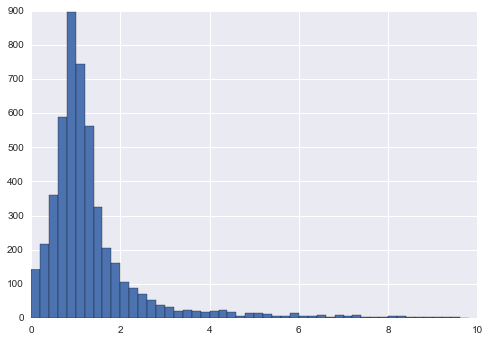

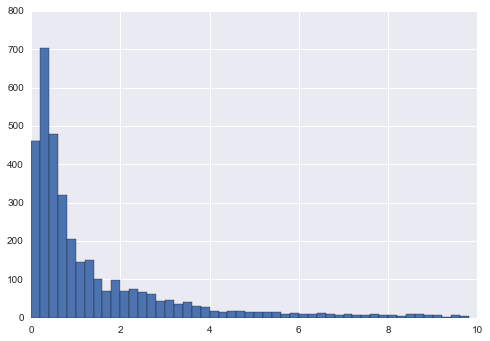

In [20]:
name_df.groupby(feature_cols).mean().ratios.hist(bins = np.arange(0, 10, .2))
plt.show()

name_df.groupby(feature_cols).std().ratios.hist(bins = np.arange(0, 10, .2))
plt.show()

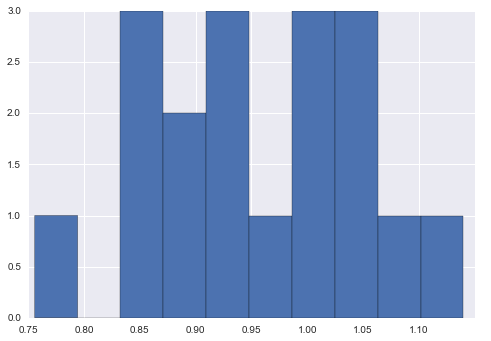

In [21]:
group_cols = ['numWords2', 'numNums2', 'numSize2', 'capNums2']
name_df[name_df.ratios < 5].groupby(group_cols).mean().ratios
name_df[name_df.ratios < 5].groupby(group_cols).mean().ratios.hist()
plt.show()

In [22]:
futureT = 64
nSamples, nName = nameFeatures.shape

X_all = timeSeries[:, :-futureT]
X_all = np.hstack((nameFeatures, X_all))
Y_all = timeSeries[:, -futureT:]

In [23]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 494) 	X_valid.shape =  (32074, 494) 	X_test.shape =  (47871, 494)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [24]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

def features(X, nName):
    means = X[:, nName:].mean(axis = 1, keepdims = True)
    result = np.hstack((X[:, :nName], means))
    return result

In [25]:
# Simple benchmark (do not use name features)

model = Pipeline([ ('features', FunctionTransformer(features, kw_args = {'nName' : nName})),
                   ('drop_name_features', FunctionTransformer(lambda X : X[:, nName:])),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
print('Smape = ', smape(1e-6 + Y_predict, Y_test))

Smape =  102.219705428


In [26]:
# Now include name features.

model = Pipeline([ ('features', FunctionTransformer(features, kw_args = {'nName' : nName})),
                   ('tree', DecisionTreeRegressor(max_depth = 20)) ])
model.fit(X_train, Y_train)
Y_predict = model.predict(X_valid)
print('Smape = ', smape(1e-6 + Y_predict, Y_valid))

Smape =  93.0507814809


depth =  1 smape =  138.596323566
depth =  4 smape =  120.680870254
depth =  7 smape =  101.932814118
depth =  10 smape =  97.9478122368
depth =  13 smape =  93.4020222159
depth =  16 smape =  91.8461474131
depth =  19 smape =  91.991091893
depth =  22 smape =  94.8673992569
depth =  25 smape =  98.5612273577
depth =  28 smape =  102.197810992


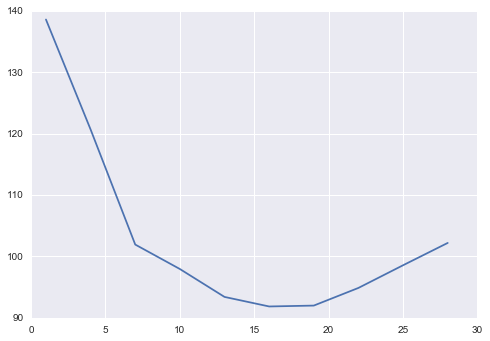

In [27]:
# Do a depth search.

model = Pipeline([ ('features', FunctionTransformer(features, kw_args = {'nName' : nName})),
                   ('tree', DecisionTreeRegressor()) ])

epsilon = 1e-6
depth_search = np.arange(1, 30, 3)
smapes = []
for depth in depth_search:
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_valid)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    smapes.append(newsmape)
    print('depth = ', depth, 'smape = ', newsmape)
    
plt.plot(depth_search, smapes)
plt.show()

0.959320003686
depth =  1 smape =  136.872034924
depth =  4 smape =  129.855508632
depth =  7 smape =  96.1440363614
depth =  10 smape =  84.7122761681
depth =  13 smape =  83.8195011531
depth =  16 smape =  85.1721923148
depth =  19 smape =  88.2899507769
depth =  22 smape =  92.7122334612
depth =  25 smape =  97.3928945541
depth =  28 smape =  101.78132067


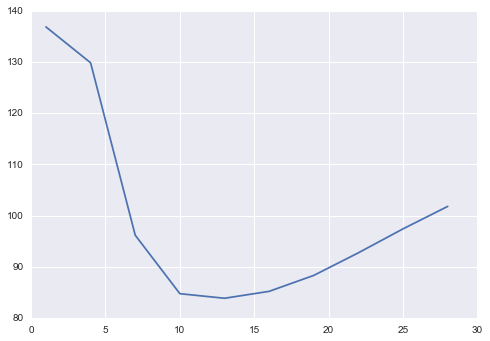

In [28]:
# Now try only training on those points with reasonable ratio of means.

cutoff = 5
Y_mean = Y_train.mean(axis = 1)
X_mean = X_train.mean(axis = 1)

ratios = Y_mean / (epsilon + X_mean)
print(np.sum(ratios < cutoff) / len(ratios))
X_train2 = X_train[ratios < cutoff]
Y_train2 = Y_train[ratios < cutoff]

depth_search = np.arange(1, 30, 3)
smapes = []
for depth in depth_search:
    model.set_params(tree__max_depth = depth)
    model.fit(X_train2, Y_train2)
    Y_predict = model.predict(X_valid)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    smapes.append(newsmape)
    print('depth = ', depth, 'smape = ', newsmape)
    
plt.plot(depth_search, smapes)
plt.show()

p =  0.5 squares =  0.0945573813044 0.0111305573935   p =  0.55 squares =  0.0825541903724 0.00952761672124   p =  0.6 squares =  0.0727616405542 0.00825161654238   p =  0.65 squares =  0.0646723164555 0.00721788280869   p =  0.7 squares =  0.0579002597014 0.00636850063721   p =  0.75 squares =  0.0521418820001 0.00566297751208   p =  0.8 squares =  0.0472242956774 0.00506933514034   p =  0.85 squares =  0.0430062353485 0.004564212925   p =  0.9 squares =  0.0393305498992 0.0041319532532   p =  0.95 squares =  0.0361144754063 0.00375878362971   p =  1.0 squares =  0.0332735948973 0.0034347493939   p =  1.05 squares =  0.0307628046676 0.00315106147208   p =  1.1 squares =  0.0285258639778 0.00290151442804   p =  1.15 squares =  0.0265447325504 0.00267997989147   p =  1.2 squares =  0.0247624784688 0.00248316126165   p =  1.25 squares =  0.023156268008 0.00230737170703   p =  1.3 squares =  0.0216925791224 0.00215012990257   p =  1.35 squares =  0.0203717627062 0.00200825278716   p =  1.

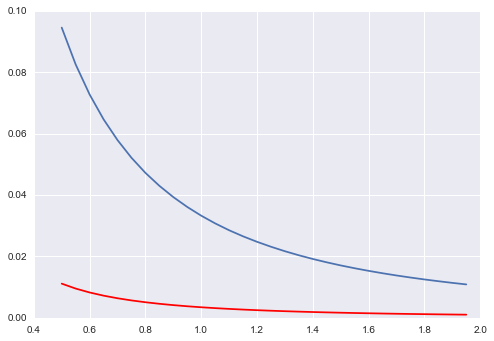

In [72]:
# Now let's combine with a z transform. First get a look at effects of z transform on average square difference above mean
# vs below mean.

param_search = np.arange(0.5, 2, 0.05)

def ztransform(Y, param):
    return np.log(param + Y)

def inverseZ(Z, param):
    return -param + np.exp(Z)

X_mean = X_train.mean(axis = 1) + epsilon

above = []
below = []

for param in param_search:
    Y_mean = Y_train.mean(axis = 1)
    ratios = np.maximum(Z_mean / X_mean, epsilon)
    ratios = ztransform(ratios, param)
    mean_ratio = ratios.mean()
    squares = (ratios - mean_ratio)**2
    squareAbove = squares[ratios > mean_ratio].mean()
    squareBelow = squares[ratios < mean_ratio].mean()
    above.append(squareAbove)
    below.append(squareBelow)
    print('p = ', param, 'squares = ', squareAbove, squareBelow, '  ', end = '')
    
plt.plot(param_search, above)
plt.plot(param_search, below, color = 'red')
plt.show()
    
    

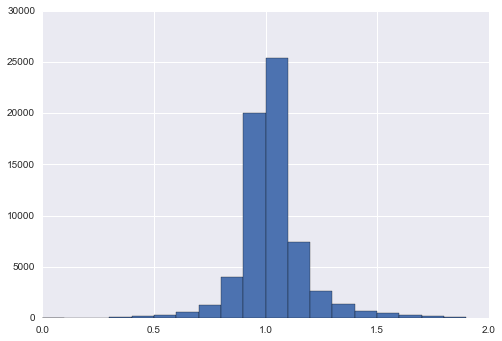

In [73]:
param = 2
Z_train = ztransform(Y_train, param)
Z_mean = Z_train.mean(axis = 1)
X_mean = ztransform(X_train, param).mean(axis = 1) + epsilon
ratios = Z_mean / X_mean
pd.Series(ratios).hist(bins = np.arange(0, 2, 0.1))
plt.show()

depth =  1 smape =  108.090309682
depth =  4 smape =  81.3817968723
depth =  7 smape =  79.7213417014
depth =  10 smape =  80.1160462565
depth =  13 smape =  82.457126876
depth =  16 smape =  87.3174663885
depth =  19 smape =  93.3986870884
depth =  22 smape =  98.6398209712
depth =  25 smape =  102.41541217
depth =  28 smape =  104.401763404


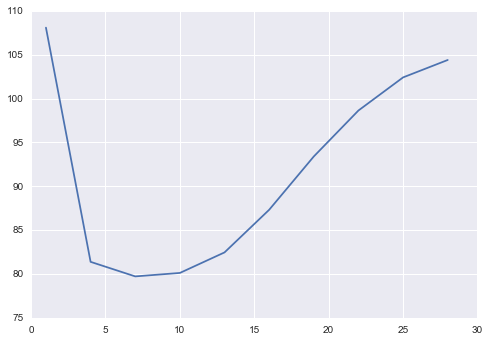

In [79]:
# Now let's do a depth search combined with z transform.

param = 2
nameFeaturesTransform = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, :nName])) ])
timesTransform = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, nName:])),
                            ('ztransform', FunctionTransformer(ztransform, kw_args = {'param' : param})),
                            ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))) ])
preTransform = FeatureUnion([ ('names', nameFeaturesTransform),
                              ('times', timesTransform) ])
model = Pipeline([ ('pre', preTransform),
                   ('tree', DecisionTreeRegressor()) ])

epsilon = 1e-6
depth_search = np.arange(1, 30, 3)
smapes = []
for depth in depth_search:
    model.set_params(tree__max_depth = depth)
    Z_train = ztransform(Y_train, param)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    smapes.append(newsmape)
    print('depth = ', depth, 'smape = ', newsmape)
    
plt.plot(depth_search, smapes)
plt.show()

depth =  1 smape =  108.326708272
depth =  4 smape =  82.3433201002
depth =  7 smape =  80.3014012374
depth =  10 smape =  80.3589078954
depth =  13 smape =  82.2986645833
depth =  16 smape =  86.8265173212
depth =  19 smape =  92.7426255991
depth =  22 smape =  98.0627445335
depth =  25 smape =  101.221504927
depth =  28 smape =  102.460739542


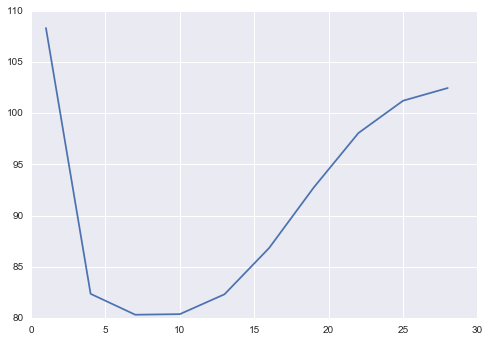

In [81]:
# Now let's combine all.

param = 2
cutoff = 5
nameFeaturesTransform = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, :nName])) ])
timesTransform = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, nName:])),
                            ('ztransform', FunctionTransformer(ztransform, kw_args = {'param' : param})),
                            ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))) ])
preTransform = FeatureUnion([ ('names', nameFeaturesTransform),
                              ('times', timesTransform) ])
model = Pipeline([ ('pre', preTransform),
                   ('tree', DecisionTreeRegressor()) ])

epsilon = 1e-6
depth_search = np.arange(1, 30, 3)
smapes = []
X_mean = X_train.mean(axis = 1) + epsilon
Y_mean = Y_train.mean(axis = 1)
ratios = Y_mean / X_mean
X_train2 = X_train[ratios < cutoff]
Y_train2 = Y_train[ratios < cutoff]

for depth in depth_search:
    model.set_params(tree__max_depth = depth)
    
    Z_train = ztransform(Y_train2, param)
    model.fit(X_train2, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    smapes.append(newsmape)
    print('depth = ', depth, 'smape = ', newsmape)
    
plt.plot(depth_search, smapes)
plt.show()